In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
import nan_cpp as nanCPP
import time
from nan_ops import NaNPool2d, NormalPool2d, NaNConv2d, NormalConv2d, NaNConv2dV2

FILENAME = "mri_data//sample_data//outp_bn3_1.pkl"
# Load the data from the pickle file
data = pickle.load(open(FILENAME, 'rb'))

if isinstance(data, tuple):
    a = data[0]
else:
    a = data

# Comparison of different pooling operations

C++ Pooling

In [ ]:
%%timeit -o -n 10 -r 3
nanoutput, nanindices = nanCPP.NaNPool2d(a, (2,2), 0.25, None)


In [ ]:
cppTime = _

Python Pooling

In [ ]:
%%timeit -o -n 10 -r 3
nanpoolPy = NaNPool2d(threshold=0.25)
nanoutputPy, nanindicesPy = nanpoolPy(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size


In [ ]:
pyTime = _

Normal Pool

In [ ]:
%%timeit -o -n 10 -r 3
normalpool = NormalPool2d(threshold=1)
normaloutput, normalindices = normalpool(a, pool_size=(2,2), strides=(2,2))  # pool_size == kernel_size


In [ ]:
normalTime = _

Torch Pool

In [ ]:
%%timeit -o -n 10 -r 3
pool = torch.nn.MaxPool2d(2, 2, return_indices=True)
torchoutput, torchindices = pool(a)


# plt.savefig('/workspace/output_comparison.png')  # Save the first plot

In [ ]:
torchTime = _

Visualizing the pooling

In [ ]:
# Visualize output
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

sns.heatmap(np.mean(nanoutput.detach().numpy().squeeze(), axis=0), ax=axes[0][0])
axes[0][0].set_title('CPP Pool Threshold 0.25')
sns.heatmap(np.mean(nanoutputPy.detach().numpy().squeeze(), axis=0), ax=axes[0][1])
axes[0][1].set_title('Python Pool Threshold 0.25')
sns.heatmap(np.mean(normaloutput.detach().numpy().squeeze(), axis=0), ax=axes[1][0])
axes[1][0].set_title('Manual Pool')
sns.heatmap(np.mean(torchoutput.detach().numpy().squeeze(), axis=0), ax=axes[1][1])
axes[1][1].set_title('Torch Pool')
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

Visualizing the difference between both

In [ ]:
# %%timeit
# Visualize output differences -- should be 0
fig, axes = plt.subplots(2, 2, figsize=(10, 7))  # Adjusted figure size for better layout

sns.heatmap(np.mean((nanoutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[0][0])
axes[0][0].set_title('CPP Pool Threshold 0.25')

sns.heatmap(np.mean((nanoutputPy - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[0][1])
axes[0][1].set_title('Python Pool Threshold 0.25')

sns.heatmap(np.mean((normaloutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[1][0])
axes[1][0].set_title('Manual Pool')

sns.heatmap(np.mean((torchoutput - torchoutput).detach().numpy().squeeze(), axis=0), ax=axes[1][1])
axes[1][1].set_title('Torch Pool')

plt.suptitle('Differences Across NaN and Torch Pool')
# plt.savefig('/workspace/differences_comparison.png')  # Save the second plot
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

Exploring the time taken for each method

In [ ]:
cpp_time = cppTime.average
py_time = pyTime.all_runs
normal_time = normalTime.all_runs
torch_time = torchTime.all_runs

cpp_time

In [ ]:
methods = ['CPP', 'Python', 'Normal', 'Torch']
times_objects = [cppTime, pyTime, normalTime, torchTime]

# Extracting the vectors from the time objects
cpp_time = cppTime.average
py_time = pyTime.average
normal_time = normalTime.average
torch_time = torchTime.average

# Extracting the standard deviations
cpp_std = cppTime.stdev
py_std = pyTime.stdev
normal_std = normalTime.stdev
torch_std = torchTime.stdev

times = [cpp_time, py_time, normal_time, torch_time]
times_stnd_dev = [cpp_std, py_std, normal_std, torch_std]

fig, ax = plt.subplots(figsize=(12, 9))  # Create a new figure with a single subplot
bars = ax.bar(methods, times, capsize=25)  # Create a bar chart
ax.set_title('Box Plot of Execution Times')
ax.set_xlabel('Methods')
ax.set_ylabel('Time (ms)')

# Adding the mean and stnd dev to make more readable
for bar, mean, std_dev in zip(bars, times, times_stnd_dev):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'Mean: {mean:.2f}\nStnd Dev: {std_dev:.2f}',
            ha='center', va='bottom')
plt.show()  # Display the figure

By observing the box plot, we notice a slight increase in execution time between the Python and C++ implementations, as expected. Interestingly, the custom-written normal pooling method is faster than the NaN pooling method. This is expected because the computational speedup for NaN layers should be realized during the custom NaN convolution operation at the cost of a slower max pooling layer. NaNPooling involves additional comparisons to check for NaNs and duplicates, and to replace these values as necessary, which is not required in normal max pooling. However, during NaNConv, some convolutions should be skipped which should mean that we will see a faster execution time.

Given Torch's highly optimized code, matching its speed with our custom layers will be challenging. However, if we can demonstrate that NaNPooling and NaNConv are faster than normal pooling and convolution, we can argue that NaN layers could outperform Torch's layers if subjected to the same level of optimization.

It can be observed that the improvement seen in our case reflect those found in pytorch's documentation found [here](https://pytorch.org/tutorials/advanced/cpp_extension.html). Their improvement takes about ~67% of the initial time whereas our takes about ~62% of our initial time. 

Documentation Example:
- Python custom implementation `Forward: 506.480 us | Backward 444.694 us`
- C++ custom implementation `Forward: 349.335 us | Backward 443.523 us`

NaN Pooling
- Python custom implementation `NaNPooling: 90.35 sec`
- C++ custom implementation `NaNPooling: 56.21 sec`

# Different Scenarios

It is observed that the threshold behaves a little differently in C++ than in the Python custom NaN implementation. Below is looking at it for different thresholds.

In [ ]:
thresholds = [0.25, 0.30, 0.50, 1]
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

for count, threshold in enumerate(thresholds):
    x = count // 2
    y = count % 2
    nanoutput, nanindices = nanCPP.NaNPool2d(a, (2,2), threshold, None)
    sns.heatmap(np.mean(nanoutput.detach().numpy().squeeze(), axis=0), ax=axes[x][y])
    axes[x][y].set_title('CPP Pool Threshold ' + str(threshold))

fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
plt.show()

# Exploring NaNConv in Python vs Normal NanConv

In [18]:
kernel = torch.randint(1,10,(2,71,6,6)).float()

In [20]:
%%timeit -o -n 10 -r 3
normalConv = NormalConv2d(kernel_size = (3,3), kernel = kernel, padding = 0)
normaloutput =  normalConv(a)  # pool_size == kernel_size


5.94 s ± 64.9 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


<TimeitResult : 5.94 s ± 64.9 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)>

In [21]:
saved_time_Normal = _
saved_time_Normal = saved_time_Normal.average

In [ ]:
%%timeit -o -n 10 -r 3
nanConv = NaNConv2d(kernel_size = (3,3), kernel = kernel, padding = 1, threshold = 1)
nanoutput = nanConv(a)

In [ ]:
saved_time_Nan = _
saved_time_Nan = saved_time_Nan.average

In [22]:
%%timeit -o -n 10 -r 3
nanConv = NaNConv2d(kernel_size = (3,3), kernel = kernel, padding = 1, threshold = 1)
nanoutput = nanConv(a)

7.18 s ± 66.1 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


<TimeitResult : 7.18 s ± 66.1 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)>

In [23]:
saved_time_NanV2 = _
saved_time_NanV2 = saved_time_Nan.averageV2

In [24]:
%%timeit -o -n 10 -r 3
torchConv = torch.nn.Conv2d(71, 2, 3, padding=1)
torchoutput = torchConv(a)

4.76 ms ± 365 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)


<TimeitResult : 4.76 ms ± 365 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)>

In [25]:
saved_time_torch = _
saved_time_torch = saved_time_torch.average

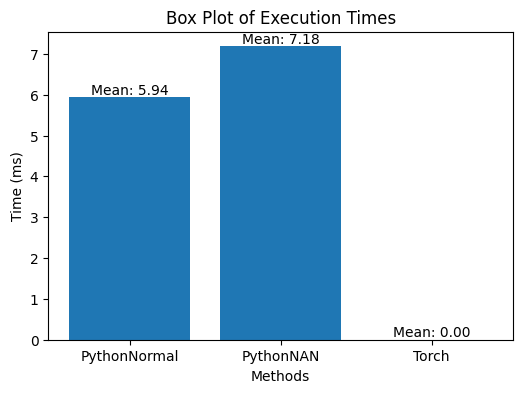

In [26]:
methods = ['PythonNormal', 'PythonNan', 'PythonNanV2', 'Torch']
times = [saved_time_Normal, saved_time_Nan, saved_time_NanV2,  saved_time_torch]

fig, ax = plt.subplots(figsize=(6, 4))  # Create a new figure with a single subplot
bars = ax.bar(methods, times, capsize=25)  # Create a bar chart
ax.set_title('Box Plot of Execution Times')
ax.set_xlabel('Methods')
ax.set_ylabel('Time (ms)')

# Adding the mean and stnd dev to make more readable
for bar, mean in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height,
            f'Mean: {mean:.2f}',
            ha='center', va='bottom')
plt.show()  # Display the figure